# In The Name Of GOD
# Fine-Grained Car Classification with PyTorch and EfficientNet-B3

**Objective:** This notebook focuses on building a robust solution for the fine-grained car classification challenge using the Stanford Cars dataset, specifically addressing **overfitting** observed in initial training runs. The goal remains to identify the specific make, model, and year of a car from an image and achieve **Accuracy, Precision, and Recall metrics all above 75%** on the validation set, ensuring strong generalization.

**Approach:** This version incorporates several strategies to combat overfitting and improve model generalization:
1.  **Load Data:** Use the Stanford Cars dataset via the Kaggle API.
2.  **More Aggressive Preprocessing & Augmentation:** Apply enhanced transformations and augmentation to increase data diversity.
3.  **Model:** Utilize **EfficientNet-B3** for its capacity, pre-trained on ImageNet.
4.  **Fine-tuning:** **Fine-tune the entire model** (base and custom classifier) with differential learning rates.
5.  **Enhanced Custom Classifier:** Modify the classifier head with `BatchNorm1d` and **increased `Dropout`**.
6.  **Regularization:** Add **Weight Decay** to the optimizer.
7.  **Training with Mixed Precision:** Implement **Mixed Precision** using `torch.cuda.amp` for efficiency.
8.  **Early Stopping:** Implement **Early Stopping** based on validation performance to halt training before overfitting becomes severe.
9.  **Longer Potential Training:** Set a higher maximum number of epochs, allowing Early Stopping to determine the optimal stopping point.
10. **Evaluation:** Calculate Accuracy, Precision (macro average), and Recall (macro average) on the validation set.
11. **Visualization:** Plot the training/validation metrics over epochs.

## 1. Setup and Imports

Imports necessary libraries for PyTorch, data handling, model loading, and metrics. Configures the computing device (GPU or CPU).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from pathlib import Path
import kaggle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from torch.cuda.amp import GradScaler, autocast

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


PyTorch Version: 2.7.0+cu126
Torchvision Version: 0.22.0+cu126
Using device: cuda


## 2. Load Data Via Kaggle and Define Transformations

Downloads the Stanford Cars dataset from Kaggle (rickyyyyyyy/torchvision-stanford-cars) and defines image transformations for training (with augmentation) and validation.

In [2]:
DATA_PATH = Path('./stanford_cars_kaggle')
DATA_PATH.mkdir(parents=True, exist_ok=True)

print(f"Checking Kaggle dataset to {DATA_PATH}...")

# Define expected dataset paths within the download directory
TRAIN_DATA_DIR = DATA_PATH / 'stanford_cars/cars_train'
TEST_DATA_DIR = DATA_PATH / 'stanford_cars/cars_test'

# Check if core dataset directories exist to avoid re-downloading
if not TRAIN_DATA_DIR.exists() or not TEST_DATA_DIR.exists():
    print("Dataset not found locally, downloading from Kaggle...")
    try:
        kaggle.api.dataset_download_files(
            'rickyyyyyyy/torchvision-stanford-cars', 
            path=DATA_PATH, 
            unzip=True
        )
        print("Kaggle dataset download and extraction complete.")
    except Exception as e:
        print(f"Error interacting with Kaggle API: {e}")
else:
    print("Dataset already found locally.")
    
# Define the root path for loading the model
ROOT_DATA_PATH = DATA_PATH

INPUT_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((INPUT_SIZE + 32, INPUT_SIZE + 32)),
        transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets and DataLoaders
BATCH_SIZE = 32
image_datasets = {
    'train': datasets.StanfordCars(root=ROOT_DATA_PATH, split='train', download=False, transform=data_transforms['train']),
    'val': datasets.StanfordCars(root=ROOT_DATA_PATH, split='test', download=False, transform=data_transforms['val'])
}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=BATCH_SIZE,
                             shuffle=(x=='train'),
                             num_workers=min(os.cpu_count() // 2, 8) if os.cpu_count() else 0)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("\nDataset loaded successfully.")
print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['val']}")
print(f"Number of classes: {num_classes}")


Checking Kaggle dataset to stanford_cars_kaggle...
Dataset already found locally.

Dataset loaded successfully.
Number of training images: 8144
Number of validation images: 8041
Number of classes: 196


## 3. Visualize Some Data

Defines a helper function to display images and shows a batch of augmented training data.

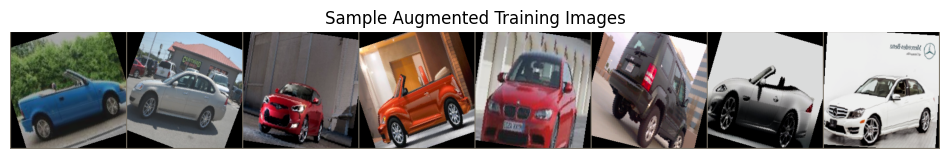

In [3]:
def imshow(inp, title=None):
    """Displays an image tensor. Reverses normalization."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

inputs, classes_idx = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title="Sample Augmented Training Images")


## 4. Define the Model (EfficientNet-B3 with Fine-tuning and Dropout)

Loads a pre-trained EfficientNet-B3 model (ImageNet) and replaces its classifier head for the new number of classes. The base layers are kept trainable for fine-tuning.

In [4]:
print(f"Loading EfficientNet-B3 model for {num_classes} classes...")

model_ft = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

num_ftrs = model_ft.classifier[1].in_features
print(f"Number of features before original classifier: {num_ftrs}")

print(f"Replacing classifier head with new layers for {num_classes} classes...")
model_ft.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(p=0.7, inplace=True),
    nn.Linear(num_ftrs, num_classes)
)

model_ft = model_ft.to(device)

print("\nModel architecture (Classifier Head Only):")
print(model_ft.classifier)

Loading EfficientNet-B3 model for 196 classes...
Number of features before original classifier: 1536
Replacing classifier head with new layers for 196 classes...

Model architecture (Classifier Head Only):
Sequential(
  (0): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.7, inplace=True)
  (2): Linear(in_features=1536, out_features=196, bias=True)
)


## 5. Define Loss Function, Optimizer, and Scheduler

Sets up the CrossEntropyLoss, AdamW optimizer with differential learning rates and weight decay for fine-tuning, and StepLR scheduler. Initializes the GradScaler for mixed precision training.

In [5]:
criterion = nn.CrossEntropyLoss()

print("Setting up optimizer with parameter groups for fine-tuning and weight decay...")
optimizer_ft = optim.AdamW([
    {'params': model_ft.classifier.parameters(), 'lr': 0.001, 'weight_decay': 0.0005},
    {'params': model_ft.features.parameters(), 'lr': 0.0001, 'weight_decay': 0.0005}
], lr=0.0001, weight_decay=0.0005)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("Initializing GradScaler for Mixed Precision...")
scaler = GradScaler()

Setting up optimizer with parameter groups for fine-tuning and weight decay...
Initializing GradScaler for Mixed Precision...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\1572991494.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 6. Training and Evaluation Function with Early Stopping and Mixed Precision

This function train and validate the model. Includes implementation for Early Stopping based on validation accuracy and uses Mixed Precision for efficiency.

In [8]:
def train_model(model, criterion, optimizer, scheduler, scaler, num_epochs=25, patience=10):
    """Trains the model and validates it with Early Stopping and Mixed Precision."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_prec = 0.0
    best_rec = 0.0

    best_val_acc_for_es = -float('inf')
    epochs_no_improve = 0
    early_stop_triggered = False

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_prec': [], 'val_rec': []}

    print("Starting Training...")
    print(f"Early Stopping Patience: {patience} epochs")
    print("="*30)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train':
                   optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast(enabled=(device.type == 'cuda')):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    all_preds.append(preds)
                    all_labels.append(labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                 history['train_loss'].append(epoch_loss)
                 history['train_acc'].append(epoch_acc.item())
                 scheduler.step()
            else:
                all_preds_tensor = torch.cat(all_preds).cpu().numpy()
                all_labels_tensor = torch.cat(all_labels).cpu().numpy()

                precision, recall, fscore, _ = precision_recall_fscore_support(
                    all_labels_tensor, all_preds_tensor, average='macro', zero_division=0
                )
                epoch_prec = precision
                epoch_rec = recall

                print(f'Validation Precision (Avg): {epoch_prec:.4f}')
                print(f'Validation Recall (Avg): {epoch_rec:.4f}')

                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                history['val_prec'].append(epoch_prec)
                history['val_rec'].append(epoch_rec)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_prec = epoch_prec
                    best_rec = epoch_rec
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f"New overall best validation acc found: {best_acc:.4f} \n")
                    print(f"(Prec: {best_prec:.4f}, Rec: {best_rec:.4f}) \n")

                if epoch_acc > best_val_acc_for_es:
                    best_val_acc_for_es = epoch_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"Validation accuracy did not improve. Patience: {epochs_no_improve}/{patience}")

                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation accuracy for {patience} epochs.")
                    early_stop_triggered = True
                    break

        print()

        if early_stop_triggered:
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_acc:4f}')
    print(f'Precision at Best Validation Acc: {best_prec:4f}')
    print(f'Recall at Best Validation Acc: {best_rec:4f}')

    if best_acc > 0.75 and best_prec > 0.75 and best_rec > 0.75:
        print("\nProject requirements MET! (Acc, Prec, Rec > 75% on validation set at best epoch)")
    else:
        print("\nProject requirements NOT MET based on best validation epoch")

    model.load_state_dict(best_model_wts)
    return model, history


## 7. Train the Model

Initiates the training process with number of epochs and early stopping patience.

In [9]:
NUM_EPOCHS = 20
PATIENCE = 5

print(f"Starting training with a maximum of {NUM_EPOCHS} epochs and Early Stopping patience of {PATIENCE}.")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, scaler,
                                  num_epochs=NUM_EPOCHS, patience=PATIENCE)

Starting training with a maximum of 20 epochs and Early Stopping patience of 5.
Starting Training...
Early Stopping Patience: 5 epochs
Epoch 1/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 4.1880 Acc: 0.1333
Val Loss: 2.8859 Acc: 0.3602
Validation Precision (Avg): 0.4247
Validation Recall (Avg): 0.3594
New overall best validation acc found: 0.3602 

(Prec: 0.4247, Rec: 0.3594) 


Epoch 2/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 2.6699 Acc: 0.3561
Val Loss: 1.6850 Acc: 0.5631
Validation Precision (Avg): 0.6175
Validation Recall (Avg): 0.5620
New overall best validation acc found: 0.5631 

(Prec: 0.6175, Rec: 0.5620) 


Epoch 3/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 1.7759 Acc: 0.5330
Val Loss: 1.2225 Acc: 0.6647
Validation Precision (Avg): 0.7038
Validation Recall (Avg): 0.6623
New overall best validation acc found: 0.6647 

(Prec: 0.7038, Rec: 0.6623) 


Epoch 4/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 1.3024 Acc: 0.6440
Val Loss: 1.0159 Acc: 0.7206
Validation Precision (Avg): 0.7458
Validation Recall (Avg): 0.7197
New overall best validation acc found: 0.7206 

(Prec: 0.7458, Rec: 0.7197) 


Epoch 5/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 1.0325 Acc: 0.7033
Val Loss: 0.8832 Acc: 0.7515
Validation Precision (Avg): 0.7740
Validation Recall (Avg): 0.7509
New overall best validation acc found: 0.7515 

(Prec: 0.7740, Rec: 0.7509) 


Epoch 6/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.8028 Acc: 0.7687
Val Loss: 0.8038 Acc: 0.7761
Validation Precision (Avg): 0.7922
Validation Recall (Avg): 0.7751
New overall best validation acc found: 0.7761 

(Prec: 0.7922, Rec: 0.7751) 


Epoch 7/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.6594 Acc: 0.8039
Val Loss: 0.7714 Acc: 0.7914
Validation Precision (Avg): 0.8062
Validation Recall (Avg): 0.7904
New overall best validation acc found: 0.7914 

(Prec: 0.8062, Rec: 0.7904) 


Epoch 8/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.5100 Acc: 0.8460
Val Loss: 0.7145 Acc: 0.8060
Validation Precision (Avg): 0.8154
Validation Recall (Avg): 0.8054
New overall best validation acc found: 0.8060 

(Prec: 0.8154, Rec: 0.8054) 


Epoch 9/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.4740 Acc: 0.8593
Val Loss: 0.6957 Acc: 0.8122
Validation Precision (Avg): 0.8206
Validation Recall (Avg): 0.8117
New overall best validation acc found: 0.8122 

(Prec: 0.8206, Rec: 0.8117) 


Epoch 10/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.4363 Acc: 0.8678
Val Loss: 0.6849 Acc: 0.8133
Validation Precision (Avg): 0.8210
Validation Recall (Avg): 0.8127
New overall best validation acc found: 0.8133 

(Prec: 0.8210, Rec: 0.8127) 


Epoch 11/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.4227 Acc: 0.8728
Val Loss: 0.6725 Acc: 0.8162
Validation Precision (Avg): 0.8231
Validation Recall (Avg): 0.8159
New overall best validation acc found: 0.8162 

(Prec: 0.8231, Rec: 0.8159) 


Epoch 12/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.4022 Acc: 0.8732
Val Loss: 0.6594 Acc: 0.8191
Validation Precision (Avg): 0.8258
Validation Recall (Avg): 0.8187
New overall best validation acc found: 0.8191 

(Prec: 0.8258, Rec: 0.8187) 


Epoch 13/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3963 Acc: 0.8762
Val Loss: 0.6531 Acc: 0.8219
Validation Precision (Avg): 0.8288
Validation Recall (Avg): 0.8210
New overall best validation acc found: 0.8219 

(Prec: 0.8288, Rec: 0.8210) 


Epoch 14/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3683 Acc: 0.8849
Val Loss: 0.6441 Acc: 0.8254
Validation Precision (Avg): 0.8333
Validation Recall (Avg): 0.8251
New overall best validation acc found: 0.8254 

(Prec: 0.8333, Rec: 0.8251) 


Epoch 15/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3437 Acc: 0.8931
Val Loss: 0.6471 Acc: 0.8233
Validation Precision (Avg): 0.8299
Validation Recall (Avg): 0.8227
Validation accuracy did not improve. Patience: 1/5

Epoch 16/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3470 Acc: 0.8959
Val Loss: 0.6400 Acc: 0.8260
Validation Precision (Avg): 0.8324
Validation Recall (Avg): 0.8253
New overall best validation acc found: 0.8260 

(Prec: 0.8324, Rec: 0.8253) 


Epoch 17/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3467 Acc: 0.8926
Val Loss: 0.6445 Acc: 0.8245
Validation Precision (Avg): 0.8312
Validation Recall (Avg): 0.8242
Validation accuracy did not improve. Patience: 1/5

Epoch 18/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3472 Acc: 0.8896
Val Loss: 0.6382 Acc: 0.8256
Validation Precision (Avg): 0.8319
Validation Recall (Avg): 0.8253
Validation accuracy did not improve. Patience: 2/5

Epoch 19/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3491 Acc: 0.8938
Val Loss: 0.6383 Acc: 0.8251
Validation Precision (Avg): 0.8313
Validation Recall (Avg): 0.8243
Validation accuracy did not improve. Patience: 3/5

Epoch 20/20
----------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17636\2540827604.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Train Loss: 0.3429 Acc: 0.8951
Val Loss: 0.6367 Acc: 0.8266
Validation Precision (Avg): 0.8329
Validation Recall (Avg): 0.8263
New overall best validation acc found: 0.8266 

(Prec: 0.8329, Rec: 0.8263) 


Training complete in 31m 20s
Best Validation Accuracy: 0.826638
Precision at Best Validation Acc: 0.832949
Recall at Best Validation Acc: 0.826253

Project requirements MET! (Acc, Prec, Rec > 75% on validation set at best epoch)


## 8. Plot Training History

This final cell visualize the key training and validation metrics collected during the model training process.

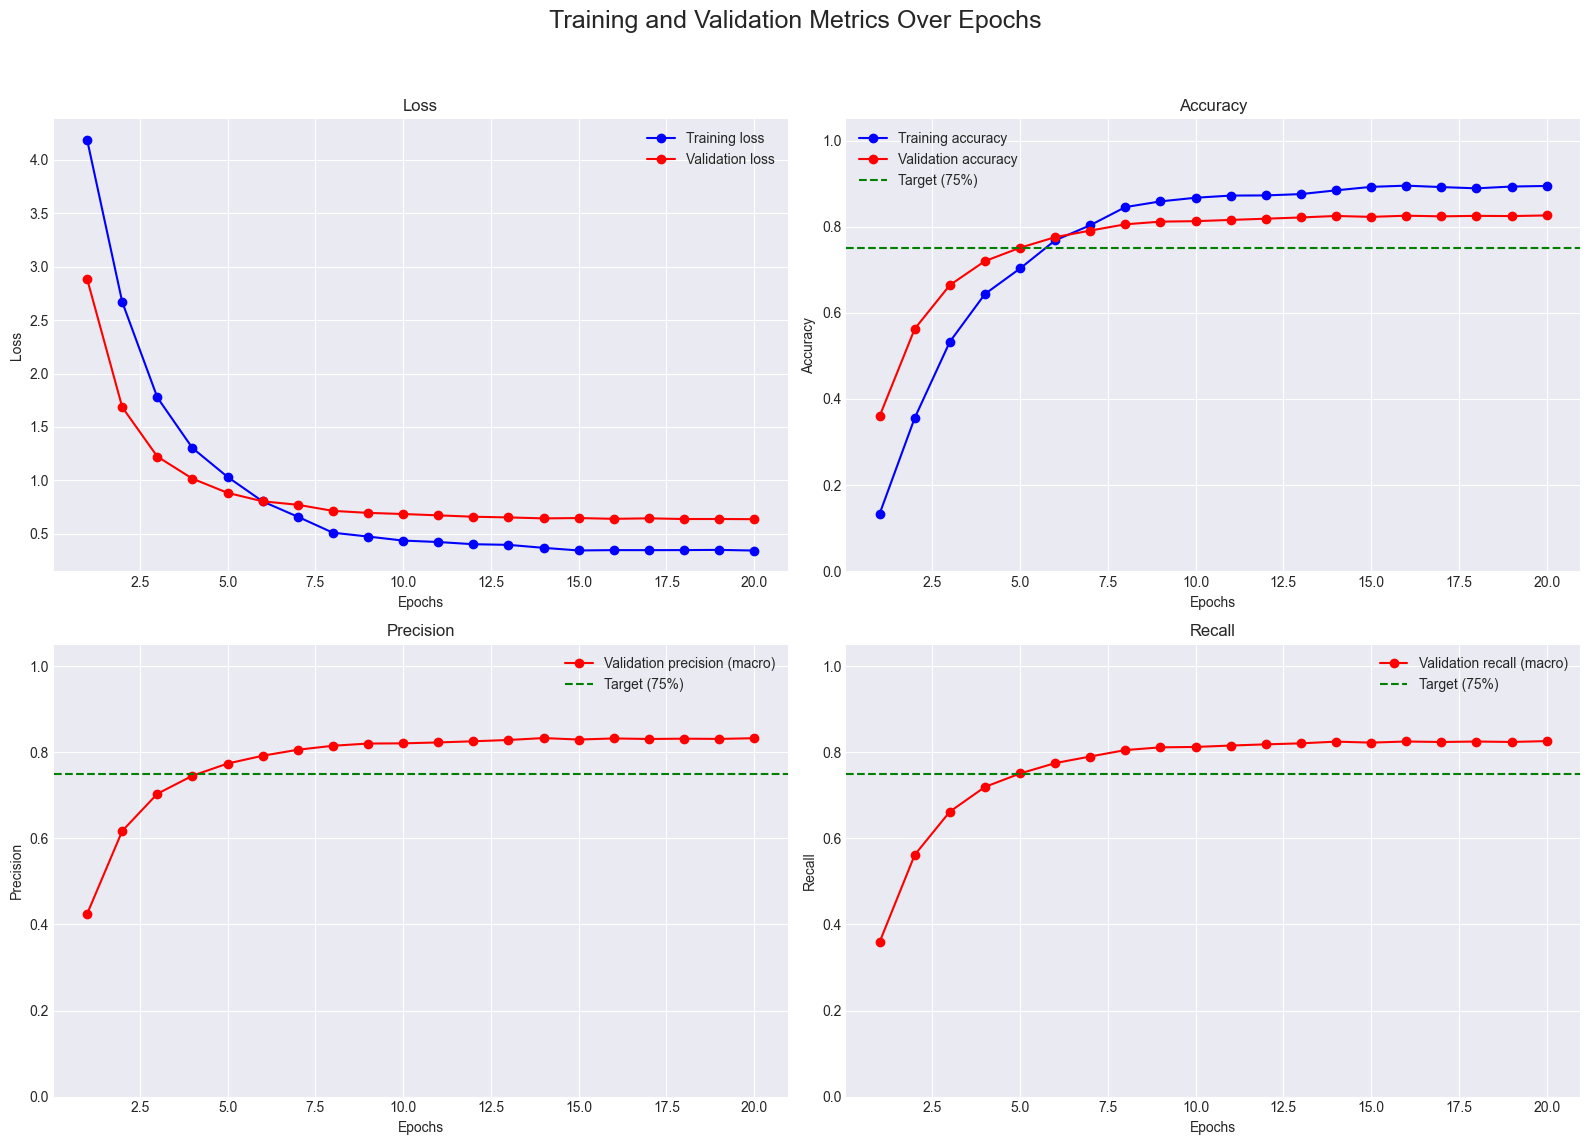

In [10]:
# Define plot_history function
def plot_history(history):

    epochs = range(1, len(history['train_loss']) + 1)

    plt.style.use('seaborn-v0_8-darkgrid') #
    fig, axs = plt.subplots(2, 2, figsize=(16, 12)) 
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=18)

    # Plot Loss
    axs[0, 0].plot(epochs, history['train_loss'], 'bo-', label='Training loss')
    axs[0, 0].plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot Accuracy
    axs[0, 1].plot(epochs, history['train_acc'], 'bo-', label='Training accuracy')
    axs[0, 1].plot(epochs, history['val_acc'], 'ro-', label='Validation accuracy')
    axs[0, 1].axhline(y=0.75, color='g', linestyle='--', label='Target (75%)')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0, 1.05) 
    axs[0, 1].legend()

    # Plot Precision
    axs[1, 0].plot(epochs, history['val_prec'], 'ro-', label='Validation precision (macro)')
    axs[1, 0].axhline(y=0.75, color='g', linestyle='--', label='Target (75%)') 
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_ylim(0, 1.05) 
    axs[1, 0].legend()

    # Plot Recall
    axs[1, 1].plot(epochs, history['val_rec'], 'ro-', label='Validation recall (macro)')
    axs[1, 1].axhline(y=0.75, color='g', linestyle='--', label='Target (75%)')
    axs[1, 1].set_title('Recall')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_ylim(0, 1.05) 
    axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

plot_history(history)

## 9. Save the Trained Model

Saves the state dictionary of the best trained model to disk.

In [ ]:
model_save_path = 'best_car_classifier_model.pth'

torch.save(model_ft.state_dict(), model_save_path)
print(f"Best model weights saved successfully to {model_save_path}")

Best model weights saved successfully to best_car_classifier_model.pth


### Developed By Eiliya Mohebi For Filoger Advanced Computer Vision Course.